In [347]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

In [348]:
df = pd.read_csv('data.csv')

In [349]:
x = df[['country', 'year', 'uniqueid', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]


y = df[['bank_account']]

x_tr, x_test, y_tr, y_test = train_test_split(x, y,test_size=.25, random_state=12)

In [350]:
x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
x_tr['is_male'] = np.where(x_tr['gender_of_respondent'] == 'Male',1,0)

<ipython-input-350-02e3f9e08314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
<ipython-input-350-02e3f9e08314>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
<ipython-input-350-02e3f9e08314>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [351]:
x_tr_cont = x_tr[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_tr_cat = x_tr[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [352]:
# Regroup to reduce number of categories
x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[x_tr_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[x_tr_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[x_tr_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-352-fd79ac22a8b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-352-fd79ac22a8b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [353]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_tr_cat)

ohe_x_train = ohe.transform(x_tr_cat)

columns = ohe.get_feature_names(['county','relationship_with_head', 'marital_status',
       'education_level', 'job_type'])

ohe_x_tr_df = pd.DataFrame(ohe_x_train, columns=columns, index=x_tr.index)

In [354]:
combo_train_df = pd.concat([x_tr_cont, ohe_x_tr_df], axis=1)

In [355]:
# Create dummy variable for bank account
y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)

<ipython-input-355-b1430f2c33c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)


In [356]:
x_train, x_val, y_train, y_val = train_test_split(combo_train_df, y_tr, test_size=.20, random_state=11)

In [357]:
y_train.drop(columns='bank_account',inplace=True)
y_val.drop(columns='bank_account',inplace=True)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


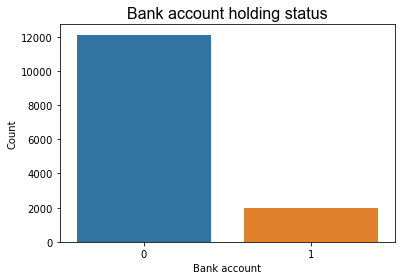

In [389]:
sns.countplot(x='bank_acc', data=df_train)
plt.title('Bank account holding status',family='arial',fontsize=16)
plt.xlabel('Bank account')
plt.ylabel('Count')
plt.show;

In [390]:
count_no_acc = len(df_train[df_train['bank_acc']==0])
count_acc = len(df_train[df_train['bank_acc']==1])
pct_of_no_acc = count_no_acc/(count_no_acc+count_acc)
print("percentage of no account:", pct_of_no_acc*100)
pct_of_acc = count_acc/(count_no_acc+count_acc)
print("percentage of account", pct_of_acc*100)

percentage of no account: 85.9288649567805
percentage of account 14.071135043219499


Classes are __very imbalanced__

In [358]:
df_train = pd.concat([x_train,y_train],axis=1)
df_val = pd.concat([x_val,y_val],axis=1)

In [359]:
# Create dateframes to use for visualisations
df_vis_cont = pd.concat([x_tr_cont,y_tr],axis=1)
df_vis_cat = pd.concat([ohe_x_tr_df,y_tr],axis=1)

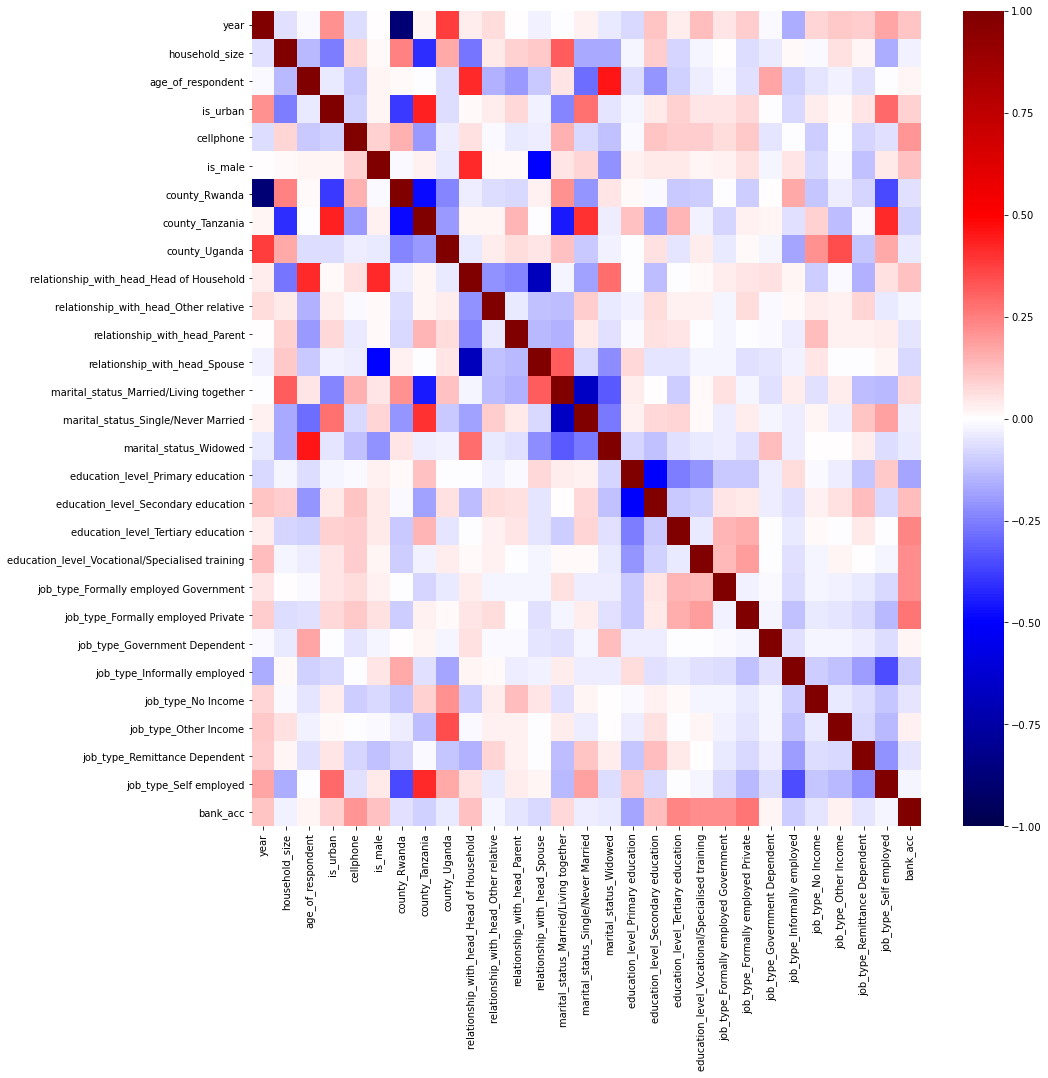

In [391]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_vis.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

In [361]:
#fig, ax = plt.subplots(figsize=(15, 15))
#pd.plotting.scatter_matrix(df_vis_cont[df_vis_cont.columns[0:]], ax=ax);

<ipython-input-362-8032c2cd83a9>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(df_vis_cat[df_vis_cat.columns[0:]], ax=ax);


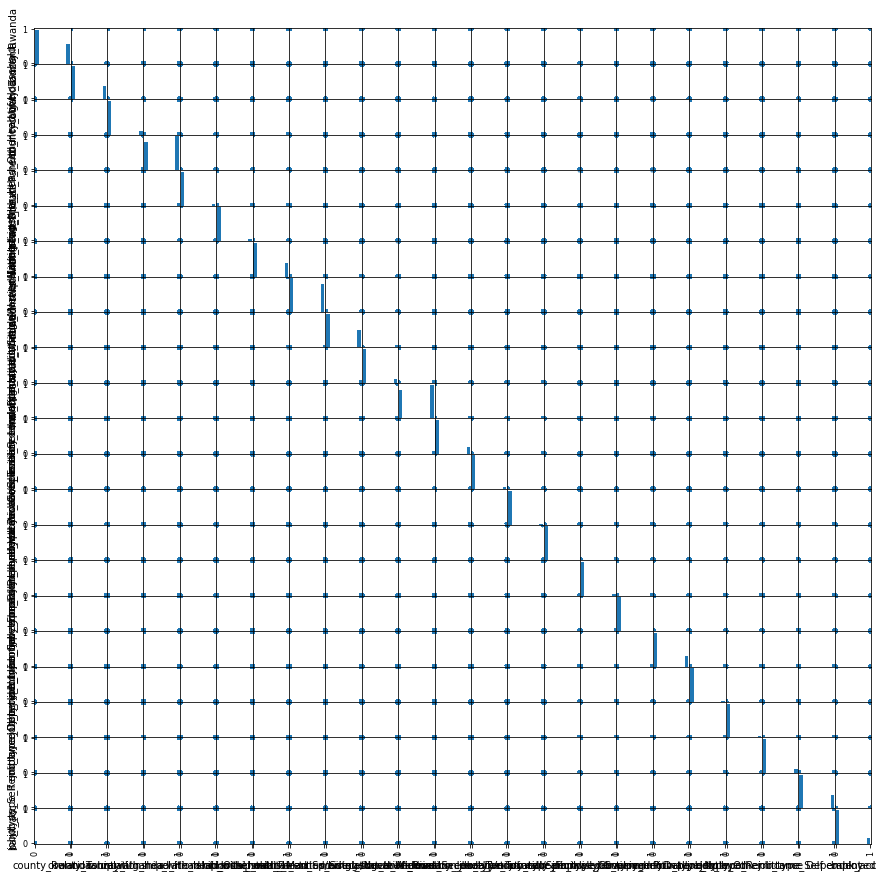

In [362]:
#fig, ax = plt.subplots(figsize=(15, 15))
#pd.plotting.scatter_matrix(df_vis_cat[df_vis_cat.columns[0:]], ax=ax);

## Simple logistic regression

Testing with a single variable: is_male

In [364]:
#Model on is_male first
lm_1 = sm.Logit(df_train['bank_acc'],  # with statsmodels, `y` comes first
                sm.add_constant(df_train[['is_male']]))  # and then `x`
lm_1 = lm_1.fit()

Optimization terminated successfully.
         Current function value: 0.399382
         Iterations 6


In [365]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               bank_acc   No. Observations:                14114
Model:                          Logit   Df Residuals:                    14112
Method:                           MLE   Df Model:                            1
Date:                Wed, 27 Jan 2021   Pseudo R-squ.:                 0.01691
Time:                        15:45:47   Log-Likelihood:                -5636.9
converged:                       True   LL-Null:                       -5733.9
Covariance Type:            nonrobust   LLR p-value:                 4.398e-44
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1251      0.035    -60.055      0.000      -2.194      -2.056
is_male        0.6779      0.049     13.887      0.000       0.582       0.774
==============================================================================
"""

In [366]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(df_train[['is_male']], df_train['bank_acc'])

LogisticRegression(C=100000, solver='newton-cg')

In [367]:
print('intercept: ', round(lm_1.intercept_[0], 4))
print('is_male coef: ', round(lm_1.coef_[0][0], 4))

intercept:  -2.1251
is_male coef:  0.6779


In [368]:
df_eval = df_val.copy()
df_eval['pred'] = lm_1.predict(df_val[['is_male']])
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['bank_acc']

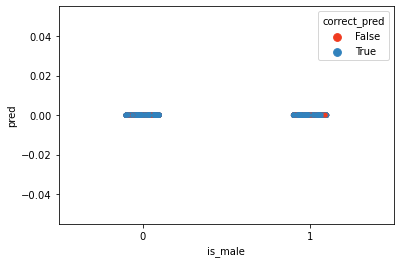

In [369]:
sns.stripplot(data=df_eval,
              x='is_male',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [370]:
lm_1.predict_proba(df_val[['is_male']])[:5]

array([[0.89331742, 0.10668258],
       [0.80955703, 0.19044297],
       [0.89331742, 0.10668258],
       [0.89331742, 0.10668258],
       [0.80955703, 0.19044297]])

In [371]:
confusion_matrix(df_eval['bank_acc'], df_eval['pred'])

array([[3037,    0],
       [ 492,    0]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 3037 | 0|
| **is account (1)** | 492 | 0 |

I believe it is predicting all no account because of the following:
* Classes are very imbalanced (85:15 no account to account)
* One variable alone may not be sufficient enough in this instance
* Perhaps because is_male class is also imbalanced?

## Multiple regression
The below analysis is a multiple logistic regression for all features 

__IMPORTANT QUESTION__: Do I need to do some sort of transformation on y given how imbalanced the classes are?

In [372]:
features = ['household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

scaler = StandardScaler()
x_train1 = scaler.fit_transform(df_train[features])
y_train1 = df_train['bank_acc']

In [375]:
logit_model=sm.Logit(y_train1,x_train1)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.601423
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.480    
Dependent Variable: bank_acc         AIC:              17030.9785
Date:               2021-01-27 15:46 BIC:              17234.9614
No. Observations:   14114            Log-Likelihood:   -8488.5   
Df Model:           26               LL-Null:          -5733.9   
Df Residuals:       14087            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        -0.0068     0.0223   -0.3028   0.7621   -0.0505    0.0370
x2         0.0787     0.0244    3.2231   0.0013    0.0308 

Is it correct to start by checking this? And thereafter filter the features that are not significant?

In [330]:
lm_2 = LogisticRegression()  

In [331]:
lm_2.fit(x_train1, y_train1)

LogisticRegression()

In [388]:
x_val1 = scaler.transform(df_val[features])
preds = lm_2.predict(x_val1)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_2.score(x_val1, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [333]:
confusion_matrix(df_val['bank_acc'], 
                 preds)

array([[2958,   79],
       [ 324,  168]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 2958 | 79|
| **is account (1)** | 324 | 168 |

Need to understand the __trade off between recall and precision__

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [432]:
from sklearn.metrics import classification_report
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3037
           1       0.68      0.34      0.45       492

    accuracy                           0.89      3529
   macro avg       0.79      0.65      0.69      3529
weighted avg       0.87      0.89      0.87      3529



In [334]:
df_val['proba_bank'] = lm_2.predict_proba(df_val[['household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']])[:, 1]

In [335]:
fpr, tpr, thresholds = roc_curve(df_val['bank_acc'],
                                 df_val['proba_bank'])

In [336]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

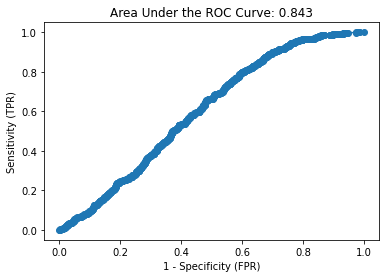

In [337]:
plot_roc(df_val['bank_acc'], lm_2.predict_proba(x_val1)[:, 1])

Need to better understand what this means - refer back to the video

In [338]:
mask = tpr > 0.9
thresholds[mask].max()

0.9857021872096586

Where does this threshold go / how do I use this? 

## Multiple regression (significant features only)

Based on logit summary above

In [418]:
x_train_3 = df_train.drop(columns = ['year', 'household_size', 'relationship_with_head_Other relative',
       'relationship_with_head_Parent',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'job_type_No Income', 'job_type_Other Income', 'job_type_Self employed',
       'bank_acc'])

df_val_3 = df_val.drop(columns = ['year', 'household_size', 'relationship_with_head_Other relative',
       'relationship_with_head_Parent',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'job_type_No Income', 'job_type_Other Income', 'job_type_Self employed',
       'bank_acc'])

In [419]:
features3 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed',
       'job_type_Remittance Dependent']

In [420]:
scaler3 = StandardScaler()
x_train3 = scaler3.fit_transform(x_train_3[features3])
y_train3 = df_train['bank_acc']

In [421]:
lm_3 = LogisticRegression()  

In [422]:
lm_3.fit(x_train3, y_train3)

LogisticRegression()

In [423]:
lm_3 = LogisticRegression()

In [424]:
lm_3.fit(x_train3, y_train3)

LogisticRegression()

In [429]:
x_val3 = scaler3.transform(df_val_3[features3])
preds3 = lm_3.predict(x_val3)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_3.score(x_val3, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [430]:
confusion_matrix(df_val['bank_acc'], 
                 preds3)

array([[2959,   78],
       [ 327,  165]])

## Testing the model on the test set

1. Preparing the test sample

In [380]:
x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
x_test['is_male'] = np.where(x_test['gender_of_respondent'] == 'Male',1,0)

<ipython-input-380-120e2e6065ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
<ipython-input-380-120e2e6065ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
<ipython-input-380-120e2e6065ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [381]:
x_test_cont = x_test[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_test_cat = x_test[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [382]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_test_cat)

ohe_x_test = ohe.transform(x_test_cat)

columns = ohe.get_feature_names(['county','relationship_with_head', 'marital_status',
       'education_level', 'job_type'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=x_test.index)

In [383]:
combo_test_df = pd.concat([x_test_cont, ohe_x_test_df], axis=1)

In [384]:
y_test['bank_acc'] = np.where(y_test['bank_account'] == 'Yes', 1,0)
y_test.drop(columns='bank_account',inplace=True)
df_test = pd.concat([combo_test_df,y_test],axis=1)

<ipython-input-384-52765b19127d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['bank_acc'] = np.where(y_test['bank_account'] == 'Yes', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


2. Testing the model on the test sample

In [386]:
x_test1 = scaler.transform(df_test[features])
preds1 = lm_2.predict(x_test1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lm_2.score(x_test1, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


In [387]:
confusion_matrix(df_test['bank_acc'], 
                 preds1)

array([[4898,  149],
       [ 543,  291]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 4839 | 149|
| **is account (1)** | 543 | 291 |

Need to do the following:
* Check error metrics
* Conduct cross validation
* Test with other classification models 

In [433]:
print(classification_report(y_test, preds1))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      5047
           1       0.66      0.35      0.46       834

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.70      5881
weighted avg       0.87      0.88      0.87      5881



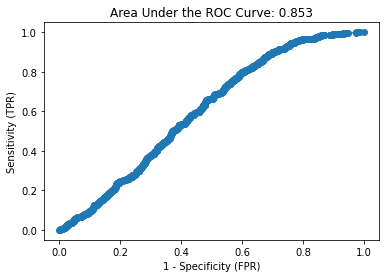

In [434]:
plot_roc(df_test['bank_acc'], lm_2.predict_proba(x_test1)[:, 1])